# Computing the GP-HT

In this example, we are going to use a simple model to illustrate how the GP-HT model works. The model consists of two ZARC elements connected in series. More details can be found in: F. Ciucci, The Gaussian process Hilbert transform (GP-HT): Testing the consistency of electrochemical impedance spectroscopy data, J. Electrochem. Soc. 167 (2020) 126503.

In [1]:
# import the libraries needed
import importlib
import GP_hilbert as gpf
importlib.reload(gpf)

import numpy as np
import matplotlib.pyplot as plt
from math import pi, log, sqrt
from scipy.optimize import minimize
import seaborn as sns

In [2]:
# plot standards
plt.rc('font', family='serif', size=15)
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

## 1) Define the synthetic impedance experiment $Z_{\rm exp}(\omega)$

### 1.1) Define frequency range

In [3]:
N_freqs = 81
freq_vec = np.logspace(-4., 4., num=N_freqs, endpoint=True)
omega_vec = 2.*pi*freq_vec

### 1.2) Define the circuit parameters

In [4]:
# define variables for exact circuit 1
R_inf_1 = 10. # Ohm
R_ct_1 = 50 # Ohm
phi_1 = 0.8 # dimensionless
tau_1 = 0.1 # s

# define variables for exact circuit 2
R_inf_2 = 10. # Ohm
R_ct_2 = 50 # Ohm
tau_2 = 1E1 # s
phi_2 = 0.8 # dimensionless

# external inductance
L_0 = 0 # F

### 1.3) Generate exact impedance $Z_{\rm exact}(\omega)$ 

In [5]:
# impedance of circuit 1
T_1 = tau_1**phi_1/R_ct_1
Z_exact_1 = R_inf_1+1./(1./R_ct_1+T_1*(1j*2.*pi*freq_vec)**phi_1)

# impedance of circuit 2
T_2 = tau_2**phi_2/R_ct_2
Z_exact_2 = R_inf_2+1./(1./R_ct_2+T_2*(1j*2.*pi*freq_vec)**phi_2)

# sum of the two
Z_exact = 1j*(2*pi*freq_vec)*L_0 + Z_exact_1 + Z_exact_2

### 1.4) Generate stochastic experiment with $Z_{\rm exp}(\omega) = Z_{\rm exact}(\omega)+ \sigma_n (\varepsilon_{\rm re} + i\varepsilon_{\rm im})$ with $\varepsilon_{\rm re}$ and $\varepsilon_{\rm im}$ are independent and identically distributed normals centered with 0 mean and standard deviation equal to 1

In [6]:
rng = np.random.seed(2421975) # seed the random number generator
sigma_n_exp = 0.8
Z_exp = Z_exact + (sigma_n_exp)*(np.random.normal(0, 1, N_freqs)+1j*np.random.normal(0, 1, N_freqs))

### 1.5) Plot

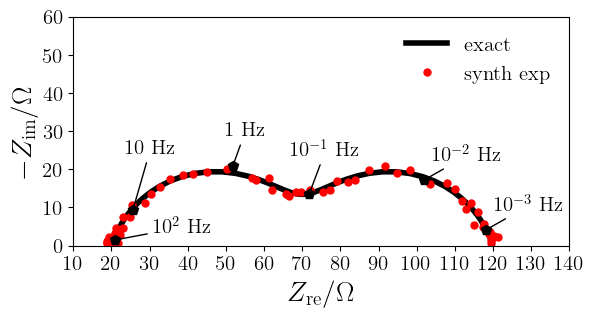

In [7]:
fig, ax = plt.subplots()

plt.plot(np.real(Z_exact), -np.imag(Z_exact), linewidth=4, color="black", label="exact")
plt.plot(np.real(Z_exp), -np.imag(Z_exp), "o", markersize=5, color="red", label="synth exp")
plt.plot(np.real(Z_exp[10:70:10]), -np.imag(Z_exp[10:70:10]), 'p', markersize=7, color="black")

plt.xlabel(r'$Z_{\rm re}/\Omega$', fontsize = 20)
plt.ylabel(r'$-Z_{\rm im}/\Omega$', fontsize = 20)
plt.annotate(r'$10^{-3}$ Hz', xy=(np.real(Z_exp[10]), -np.imag(Z_exp[10])), 
             xytext=(np.real(Z_exp[10])+2, 5-np.imag(Z_exp[10])), 
             arrowprops=dict(arrowstyle="-", connectionstyle="arc"))
plt.annotate(r'$10^{-2}$ Hz', xy=(np.real(Z_exp[20]), -np.imag(Z_exp[20])), 
             xytext=(np.real(Z_exp[20])+2, 5-np.imag(Z_exp[20])), 
             arrowprops=dict(arrowstyle="-", connectionstyle="arc"))
plt.annotate(r'$10^{-1}$ Hz', xy=(np.real(Z_exp[30]), -np.imag(Z_exp[30])), 
             xytext=(np.real(Z_exp[30])-5, 10-np.imag(Z_exp[30])), 
             arrowprops=dict(arrowstyle="-", connectionstyle="arc"))
plt.annotate(r'$1$ Hz', xy=(np.real(Z_exp[40]), -np.imag(Z_exp[40])), 
             xytext=(np.real(Z_exp[40])-2, 8-np.imag(Z_exp[40])), 
             arrowprops=dict(arrowstyle="-", connectionstyle="arc"))
plt.annotate(r'$10$ Hz', xy=(np.real(Z_exp[50]), -np.imag(Z_exp[50])), 
             xytext=(np.real(Z_exp[50])-2, 15-np.imag(Z_exp[50])), 
             arrowprops=dict(arrowstyle="-", connectionstyle="arc"))
plt.annotate(r'$10^2$ Hz', xy=(np.real(Z_exp[60]), -np.imag(Z_exp[60])), 
             xytext=(np.real(Z_exp[60])+ 10, 2-np.imag(Z_exp[60])), 
             arrowprops=dict(arrowstyle="-", connectionstyle="arc"))

plt.legend(frameon=False, fontsize=15, loc='upper right')
plt.axis('scaled')

plt.xlim(10, 140)
plt.ylim(0, 60)
plt.xticks(range(10, 150, 10))
plt.yticks(range(0, 70, 10))

plt.xlabel(r'$Z_{\rm re}/\Omega$', fontsize = 20)
plt.ylabel(r'$-Z_{\rm im}/\Omega$', fontsize = 20)
plt.show()

## 2) Optimize the hyperparameters 

### 2.1) Set the kernel options 

In [8]:
ker_opts = {
    'sigma_DRT': 30.,
    'sigma_SB': 1E-8,
    'ell': 1.,
    'tau_max': 1e2,
    'DRT': True,
    'SB': True,
    'SB_ker_type': 'IQ',
}

# these values are nominal

### 2.2) Initialize the hyperparameters

In [9]:
sigma_n = 0.75
sigma_DRT = 30
sigma_SB = 1E-8
ell = 16
sigma_L = 1E-10


### 2.3) Maximize the NMLL

In [10]:
theta_0 = np.array([sigma_n, sigma_DRT, sigma_SB, ell, sigma_L])
seq_theta = np.copy(theta_0)
def print_results(theta):
    global seq_theta
    seq_theta = np.vstack((seq_theta, theta))
    print('%.4E, %.4E, %.4E, %.4E, %.6E; evidence = %.8E'%(theta[0], theta[1], theta[2], theta[3], theta[4], gpf.NMLL_fct(theta, Z_exp.imag, omega_vec, ker_opts, 'im')))
    
res = minimize(gpf.NMLL_fct, theta_0, args=(Z_exp.imag, omega_vec, ker_opts, 'im'), method='Powell', \
               callback=print_results, options={'disp': True, 'xtol': 1E-6, 'ftol': 1E-6})
res = minimize(gpf.NMLL_fct, res.x, args=(Z_exp.imag, omega_vec, ker_opts, 'im'), method='Nelder-Mead', \
               callback=print_results, options={'disp': True, 'xatol': 1E-6, 'fatol': 1E-6})

theta = res.x
sigma_n, sigma_DRT, sigma_SB, ell, sigma_L = theta

7.5126E-01, 2.9198E+01, 1.6947E-08, 1.8618E+01, 1.658181E-15; evidence = 5.41151272E+01
7.5125E-01, 2.9198E+01, 2.3727E-08, 2.1235E+01, 1.658181E-15; evidence = 5.41151272E+01
Optimization terminated successfully.
         Current function value: 54.115127
         Iterations: 2
         Function evaluations: 239
7.5125E-01, 2.9198E+01, 2.3727E-08, 2.1235E+01, 1.658181E-15; evidence = 5.41151272E+01
7.5125E-01, 2.9198E+01, 2.3727E-08, 2.1235E+01, 1.658181E-15; evidence = 5.41151272E+01
7.5125E-01, 2.9198E+01, 2.3727E-08, 2.1235E+01, 1.658181E-15; evidence = 5.41151272E+01
7.5125E-01, 2.9198E+01, 2.3727E-08, 2.1235E+01, 1.658181E-15; evidence = 5.41151272E+01
7.5125E-01, 2.9198E+01, 2.3727E-08, 2.1235E+01, 1.658181E-15; evidence = 5.41151272E+01
7.5125E-01, 2.9198E+01, 2.3727E-08, 2.1235E+01, 1.658181E-15; evidence = 5.41151272E+01
7.5125E-01, 2.9198E+01, 2.3727E-08, 2.1235E+01, 1.658181E-15; evidence = 5.41151272E+01
7.5125E-01, 2.9198E+01, 2.3727E-08, 2.1235E+01, 1.658181E-15; evidenc

7.5125E-01, 2.9198E+01, 2.3728E-08, 2.1236E+01, 1.658222E-15; evidence = 5.41151272E+01
7.5125E-01, 2.9198E+01, 2.3728E-08, 2.1236E+01, 1.658222E-15; evidence = 5.41151272E+01
7.5125E-01, 2.9198E+01, 2.3728E-08, 2.1236E+01, 1.658222E-15; evidence = 5.41151272E+01
7.5125E-01, 2.9198E+01, 2.3728E-08, 2.1236E+01, 1.658222E-15; evidence = 5.41151272E+01
7.5125E-01, 2.9198E+01, 2.3728E-08, 2.1236E+01, 1.658222E-15; evidence = 5.41151272E+01
7.5125E-01, 2.9198E+01, 2.3728E-08, 2.1236E+01, 1.658222E-15; evidence = 5.41151272E+01
7.5125E-01, 2.9198E+01, 2.3728E-08, 2.1236E+01, 1.658222E-15; evidence = 5.41151272E+01
7.5125E-01, 2.9198E+01, 2.3728E-08, 2.1236E+01, 1.658222E-15; evidence = 5.41151272E+01
7.5125E-01, 2.9198E+01, 2.3728E-08, 2.1236E+01, 1.658222E-15; evidence = 5.41151272E+01
7.5125E-01, 2.9198E+01, 2.3728E-08, 2.1236E+01, 1.658222E-15; evidence = 5.41151272E+01
7.5125E-01, 2.9198E+01, 2.3728E-08, 2.1236E+01, 1.658222E-15; evidence = 5.41151272E+01
7.5125E-01, 2.9198E+01, 2.3728E-

In [11]:
# update the values of the kernel
# as the gpf functions simply copy ker_opts
ker_opts['sigma_SB'] = sigma_SB
ker_opts['ell'] = ell
ker_opts['sigma_DRT'] = sigma_DRT

### 2.4) Check if the results are reasonable

#### 2.4.1) Check $L_0$

In [18]:
K_im = gpf.mat_K(omega_vec, omega_vec, ker_opts, 'im')
Sigma = (sigma_n**2)*np.eye(N_freqs)
K_full = K_im + Sigma + (sigma_L**2)*np.outer(omega_vec, omega_vec)
K_full_reg = K_im + Sigma

# Cholesky-decompose K_full_reg
# begin FC - added 
if not gpf.is_PD(K_full_reg):
    K_full_reg = gpf.nearest_PD(K_full_reg)

# end FC - added 

# inverse of K_im
L = np.linalg.cholesky(K_full_reg)
inv_L = np.linalg.inv(L)
inv_K_full_reg = np.dot(inv_L.T, inv_L)

num_L_0 = omega_vec@(inv_K_full_reg@Z_exp.imag)
den_L_0 = (sigma_L**-2) + omega_vec@(inv_K_full_reg@omega_vec)
L_0_est = num_L_0/den_L_0

print('L_0_est = %.6E H vs. L_0 = %.6E H'%(L_0_est, L_0))

L_0_est = 5.692525E-26 H vs. L_0 = 0.000000E+00 H


#### 2.4.2) Check the fit of $\Im(Z_{\rm exp})$ against the GP

##### 2.4.2.1) Run the GP regression

In [19]:
# begin FC - added 
if not gpf.is_PD(K_full):
    K_full = gpf.nearest_PD(K_full)

# end FC - added 

# cholesky factorization
L = np.linalg.cholesky(K_full)

# covariance matrix
inv_L = np.linalg.inv(L)
inv_K_full = np.dot(inv_L.T, inv_L)

N_star_freqs = N_freqs
freq_star_vec = np.copy(freq_vec) #np.logspace(-4., 4., num=N_star_freqs, endpoint=True)
omega_star_vec = 2.*pi*freq_star_vec

mu_star_vec = np.zeros_like(omega_star_vec)
sigma_star_vec = np.zeros_like(omega_star_vec)

for index, omega_star in enumerate(omega_star_vec):
    #print('iter = ', index+1, '/', N_star_freqs)
    omega_star_np = np.array([omega_star])
    k_star = gpf.mat_K(omega_vec, omega_star_np, ker_opts, 'im').flatten() + (sigma_L**2)*omega_vec*omega_star_np
    k_star_star = gpf.mat_K(omega_star_np, omega_star_np, ker_opts, 'im').flatten() + (sigma_L**2)*omega_star_np**2
    mu_star_vec[index] = k_star@(inv_K_full@Z_exp.imag)
    sigma_star_vec[index] = np.sqrt(k_star_star - k_star@(inv_K_full@k_star))

##### 2.4.2.2) Plot the outcome of the GP regression

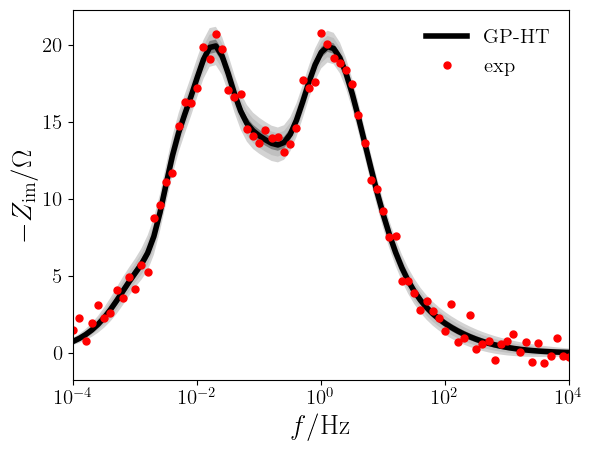

In [20]:
plt.fill_between(freq_star_vec, -mu_star_vec-3*sigma_star_vec, -mu_star_vec+3*sigma_star_vec,  facecolor='lightgrey')
plt.fill_between(freq_star_vec, -mu_star_vec-2*sigma_star_vec, -mu_star_vec+2*sigma_star_vec,  facecolor='silver')
plt.fill_between(freq_star_vec, -mu_star_vec-sigma_star_vec, -mu_star_vec+sigma_star_vec,  facecolor='grey')
plt.semilogx(freq_star_vec, -mu_star_vec, linewidth=4, color='black', label='GP-HT')
plt.semilogx(freq_vec,  -Z_exp.imag, 'o', markersize=5, color='red', label='exp')
plt.xlim(1E-4, 1E4)
plt.xscale('log')
plt.xlabel(r'$f/{\rm Hz}$', fontsize=20)
plt.ylabel(r'$-Z_{\rm im}/\Omega$', fontsize=20)
plt.legend(frameon=False, fontsize = 15)
plt.show()

## 3) Compute and plot the GP-HT 

### 3.1) Compute

In [21]:
K_im = gpf.mat_K(omega_vec, omega_vec, ker_opts, 'im')
Sigma = (sigma_n**2)*np.eye(N_freqs)
K_full = K_im + Sigma + (sigma_L**2)*np.outer(omega_vec, omega_vec)

# begin FC - added 
if not gpf.is_PD(K_full):
    K_full = gpf.nearest_PD(K_full)

# end FC - added 

# cholesky factorization
L = np.linalg.cholesky(K_full)

# covariance matrix
inv_L = np.linalg.inv(L)
inv_K_full = np.dot(inv_L.T, inv_L)

# omega star is overwritten
mu_star_vec = np.zeros_like(omega_star_vec)
sigma_star_vec = np.zeros_like(omega_star_vec)


for index, omega_star in enumerate(omega_star_vec):
    omega_star_np = np.array([omega_star])
    k_star = gpf.mat_K(omega_vec, omega_star_np, ker_opts, 'im-re').flatten()
    k_star_star = gpf.mat_K(omega_star_np, omega_star_np, ker_opts, 're').flatten()
    mu_star_vec[index] = k_star@(inv_K_full@Z_exp.imag)
    sigma_star_vec[index] = np.sqrt(sigma_n**2 + k_star_star - k_star@(inv_K_full@k_star))

### 3.2) Plot GP-HT prediction vs. experimental data

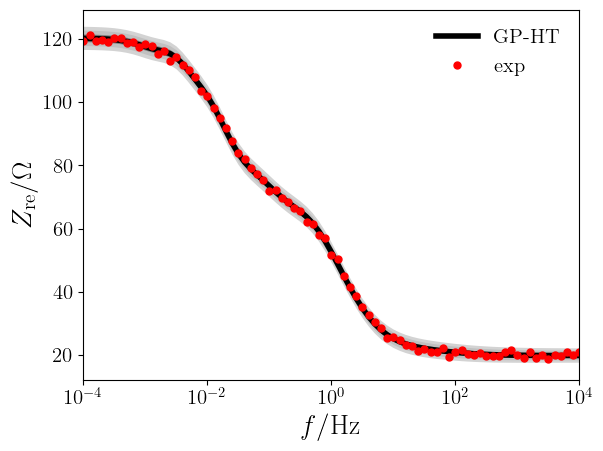

In [22]:
mu_R_inf = np.mean(Z_exp.real-mu_star_vec)
diff_re = mu_R_inf + mu_star_vec - Z_exp.real

plt.fill_between(freq_star_vec, mu_R_inf+mu_star_vec-3*sigma_star_vec, mu_R_inf+mu_star_vec+3*sigma_star_vec,  facecolor='lightgrey')
plt.fill_between(freq_star_vec, mu_R_inf+mu_star_vec-2*sigma_star_vec, mu_R_inf+mu_star_vec+2*sigma_star_vec,  facecolor='silver')
plt.fill_between(freq_star_vec, mu_R_inf+mu_star_vec-sigma_star_vec, mu_R_inf+mu_star_vec+sigma_star_vec,  facecolor='grey')
plt.semilogx(freq_star_vec, mu_R_inf+mu_star_vec, linewidth=4, color='black', label='GP-HT')
plt.semilogx(freq_vec,  Z_exp.real, 'o', markersize=5, color='red', label='exp')
plt.xlabel(r'$f/{\rm Hz}$', fontsize=20)
plt.ylabel(r'$Z_{\rm re}/\Omega$', fontsize = 20)

plt.xlim(1E-4, 1E4)
plt.xscale('log')
plt.legend(frameon=False, fontsize = 15)

plt.show()

### 3.3) Show the residuals

C:\Users\pybap\anaconda3\lib\site-packages\seaborn\distributions.py:1689: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)
C:\Users\pybap\anaconda3\lib\site-packages\seaborn\distributions.py:2112: FutureWarning: Using `vertical=True` to control the orientation of the plot  is deprecated. Instead, assign the data directly to `y`. 
  warnings.warn(msg, FutureWarning)


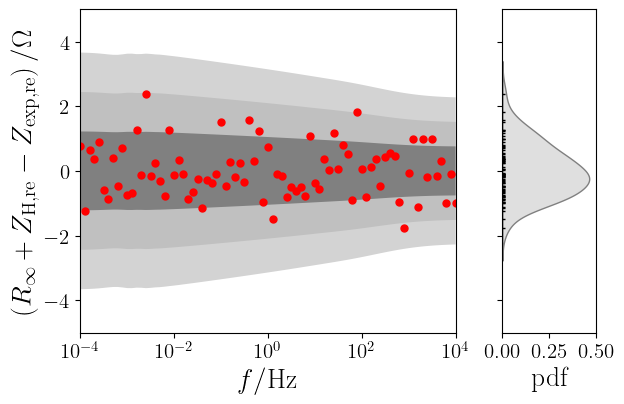

In [23]:
#  Combine the scatter plot with the density distribution
fig = plt.figure(figsize=(12,4.2), constrained_layout=False)
gs1 = fig.add_gridspec(nrows=1, ncols=4, left=0.05, right=0.48, wspace=0.5)
ax1 = fig.add_subplot(gs1[0, :-1])
ax2 = fig.add_subplot(gs1[0, -1])
ax1.fill_between(freq_vec, -3*sigma_star_vec, 3*sigma_star_vec,  facecolor='lightgrey')
ax1.fill_between(freq_vec, -2*sigma_star_vec, 2*sigma_star_vec,  facecolor='silver')
ax1.fill_between(freq_vec, -sigma_star_vec, sigma_star_vec,  facecolor='grey')
ax1.plot(freq_vec, diff_re, 'o', markersize=5, color='red')
ax1.set_xlim(1E-4, 1E4)
ax1.set_ylim(-5, 5)
ax1.set_xscale('log')
ax1.set_xlabel(r'$f/{\rm Hz}$', fontsize=20)
ax1.set_ylabel(r'$\left(R_\infty + Z_{\rm H, re} - Z_{\rm exp, re}\right)/\Omega$', fontsize=20)

# density distribution plot
sns.kdeplot(diff_re, ax=ax2, shade=True, color='grey', vertical=True)
sns.rugplot(diff_re, ax=ax2, color='black', vertical=True)
ax2.set_xlim(0, 0.5)
ax2.set_xticks(np.arange(0., 0.51, 0.25))
ax2.set_yticklabels([])
ax2.set_ylim(-5, 5)
ax2.set_xlabel(r'pdf',fontsize=20)

plt.show()